In [1]:
%reload_ext autotime
import rasterio
import requests
from rasterio.features import shapes, sieve, rasterize
from rasterio.plot import show
import geopandas as gpd
import os
import numpy as np
from tqdm.auto import tqdm
from shapely.geometry import box, shape
from rasterio.mask import mask
from matplotlib import pyplot as plt
import xdem
import time
from tqdm.contrib.concurrent import process_map
import pandas as pd
tqdm.pandas()

In [2]:
old = rasterio.open("NDVI_2018.tif")
old_data = old.read(1)
new = rasterio.open("NDVI_2023.tif")
new_data = new.read(1)
old.res, new.res

((10.0, 10.0), (10.0, 10.0))

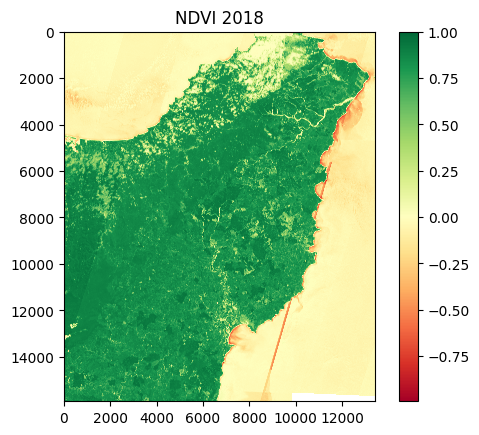

In [3]:
plt.imshow(old_data, cmap="RdYlGn")
plt.title("NDVI 2018")
plt.colorbar()

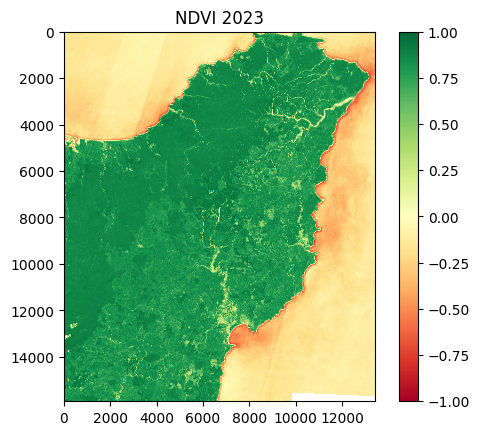

In [4]:
plt.imshow(new_data, cmap="RdYlGn")
plt.title("NDVI 2023")
plt.colorbar()

/tmp/ipykernel_178175/58089339.py:1: RuntimeWarning: invalid value encountered in subtract
  diff = new_data - old_data


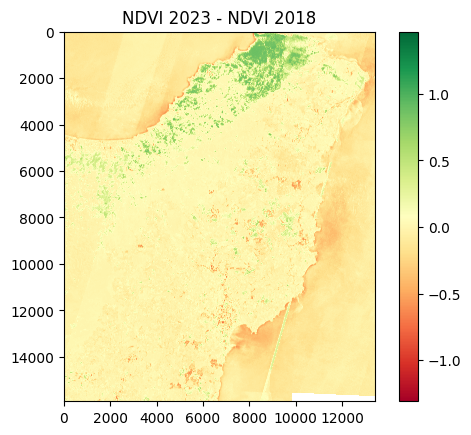

In [5]:
diff = new_data - old_data
plt.imshow(diff, cmap="RdYlGn")
plt.title("NDVI 2023 - NDVI 2018")
plt.colorbar()

In [6]:
areas = gpd.read_parquet("areas.parquet")
areas

,geometry,area,old_min,old_max,old_mean,old_median,old_std,new_min,new_max,new_mean,...,new_planform_curvature_min,new_planform_curvature_max,new_planform_curvature_mean,new_planform_curvature_median,new_planform_curvature_std,diff_planform_curvature_min,diff_planform_curvature_max,diff_planform_curvature_mean,diff_planform_curvature_median,diff_planform_curvature_std
2,"POLYGON ((2004202 5686800, 2004202 5686799, 20...",46435.0,239.875000,581.692017,432.621765,445.957001,74.112358,239.446991,582.225952,433.723755,...,-1168.404426,1070.992710,0.371720,0.176987,65.956356,-1850.208135,3137.192117,5.373005,1.279411,97.218072
3,"POLYGON ((2004467 5685771, 2004467 5685770, 20...",29403.0,497.904022,654.613953,582.098328,584.377014,34.089294,498.463989,655.286011,582.956116,...,-492.481522,701.500712,0.175093,0.126739,40.445882,-404.546788,720.480309,3.242155,1.301183,54.727808
0,"POLYGON ((2004873 5686570, 2004873 5686569, 20...",12183.0,227.065994,256.863007,235.661514,235.633011,5.262484,226.535995,257.285004,234.251129,...,-197.421854,248.658820,-0.362331,-0.027325,14.184576,-391.844280,271.695680,-1.584016,-0.475870,22.683974
1,"POLYGON ((2004160 5686276, 2004160 5686259, 20...",7936.0,426.713989,481.050018,454.960205,454.101990,11.115774,425.688995,480.164001,451.769012,...,-167.001436,241.441450,-0.104405,-0.665657,20.813181,-134.150583,247.896628,-0.507291,-1.203775,28.171378
4,"POLYGON ((2003987 5685256, 2003987 5685248, 20...",4564.0,423.951019,497.674011,455.302734,452.955505,15.822889,423.898987,496.877014,453.009827,...,-430.431501,312.396791,-6.597975,-2.694242,51.253638,-554.358201,467.979155,-15.565538,-9.080177,78.540318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37,"POLYGON ((2059678 5756841, 2059678 5756839, 20...",4735.0,71.222000,179.138000,122.841553,125.296005,26.810328,70.716003,178.631989,121.686890,...,-232.722963,172.470442,-3.028417,-0.859566,31.362350,-477.117956,349.904132,-10.499820,-7.743738,57.528584
0,"POLYGON ((2059443 5758797, 2059443 5758795, 20...",4467.0,32.271000,35.838001,35.196594,35.352001,0.617860,32.857998,36.693001,36.112537,...,-79.763715,94.858104,0.039597,0.180451,5.913490,-77.056582,101.627277,0.281014,0.116568,8.075569
4,"POLYGON ((2059696 5758532, 2059696 5758531, 20...",4440.0,24.914999,33.780998,31.295317,32.326000,2.329670,25.475000,36.038998,32.241283,...,-88.590114,103.961346,2.074886,0.873680,13.336787,-113.013243,108.612276,2.941867,1.477503,18.272839
34,"POLYGON ((2058850 5756947, 2058850 5756941, 20...",4287.0,354.406006,423.560974,393.562653,399.283997,20.062107,353.753998,422.947021,391.819214,...,-72.631808,73.052577,-2.534588,-0.993262,12.433742,-153.613620,162.610466,-4.923029,-2.738370,25.562239


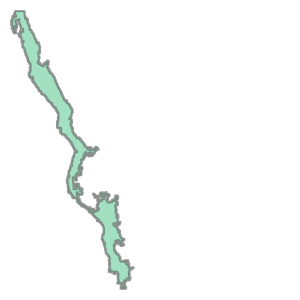

In [7]:
geom = areas.geometry.iloc[0]
geom

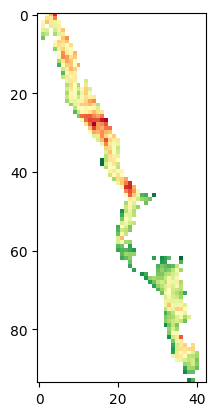

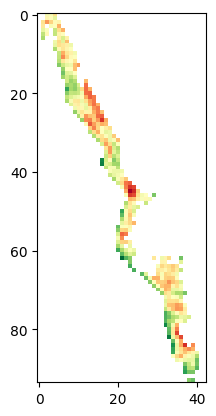

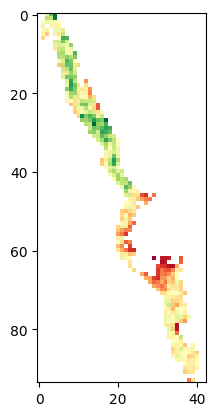

<Axes: >

In [8]:
masked_old, transform = mask(old, [geom], nodata=np.nan, crop=True)
masked_new, transform = mask(new, [geom], nodata=np.nan, crop=True)
masked_diff = masked_new - masked_old
show(masked_old, cmap="RdYlGn")
show(masked_new, cmap="RdYlGn")
show(masked_diff, cmap="RdYlGn")

In [9]:
def get_features(row):
    geom = row.geometry
    masked_old, transform = mask(old, [geom], nodata=np.nan, crop=True)
    masked_new, transform = mask(new, [geom], nodata=np.nan, crop=True)
    masked_diff = masked_new - masked_old
    row = row.to_dict()
    row.update({
        "NDVI_old_min": np.nanmin(masked_old),
        "NDVI_old_max": np.nanmax(masked_old),
        "NDVI_old_mean": np.nanmean(masked_old),
        "NDVI_old_median": np.nanmedian(masked_old),
        "NDVI_old_std": np.nanstd(masked_old),
        "NDVI_new_min": np.nanmin(masked_new),
        "NDVI_new_max": np.nanmax(masked_new),
        "NDVI_new_mean": np.nanmean(masked_new),
        "NDVI_new_median": np.nanmedian(masked_new),
        "NDVI_new_std": np.nanstd(masked_new),
        "NDVI_diff_min": np.nanmin(masked_diff),
        "NDVI_diff_max": np.nanmax(masked_diff),
        "NDVI_diff_mean": np.nanmean(masked_diff),
        "NDVI_diff_median": np.nanmedian(masked_diff),
        "NDVI_diff_std": np.nanstd(masked_diff)
    })
    return pd.Series(row)

areas = areas.progress_apply(get_features, axis=1)
areas.to_parquet(f"areas+NDVI.parquet")

  0%|          | 0/21886 [00:00<?, ?it/s]